# Risk

### VaR (Value at Risk)

We cannot eliminate market risk but we can reduce it through various means. The most popular way of accomplishing that is through diversification. Given that our strategy is market-neutral, we should be still protected even in case of a market breakdown. We can measure said risk by using VaR which calculates the maximum potential loss a portfolio could experience within a timeframe.

In [3]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

df_returns = pl.read_csv('./data/strat/returns.csv')

trade_pnl = df_returns['trade_pnl'].to_numpy()

# initial portfolio value of 1m USD
aum = 1_000_000
mu = np.mean(trade_pnl)
sigma = np.std(trade_pnl)
alpha = norm.ppf(1-0.99, mu, sigma)

print(f"The VaR on a daily basis for our strategy is ${aum-aum*(alpha+1):2.2f} with a 99% confidence")

The VaR on a daily basis for our strategy is $61241.57 with a 99% confidence


### CVaR (Conditional Value at Risk)

Next, we could also explore the conditional value at risk, or expected shortfall which refers to the worst q% of cases over a specific time period. It really is just the tail risk.

$$ES_{\alpha} (X) = -\frac{1}{\alpha} \int_{0}^{\alpha} VaR \gamma (X) d\gamma$$


In [4]:
# order trade pnl, in this case not very interesting
sorted = np.sort(trade_pnl)
cvar_index = int((1-0.99) * len(sorted))

# mean at the cutoff index
cvar = np.mean(sorted[:cvar_index])

print(f"The CVaR for our strategy is {cvar*100:2.2f}% with a 99% confidence")

The CVaR for our strategy is -1.11% with a 99% confidence


### Maximum Drawdown

Given the limited data set and, consequently, the number of trades, the maximum drawdown of the strategy is somewhat limited. In our case, we had one losing trade and the maximum drawdown was -17.2% which completely recovered in February 2024, or after 3 months.

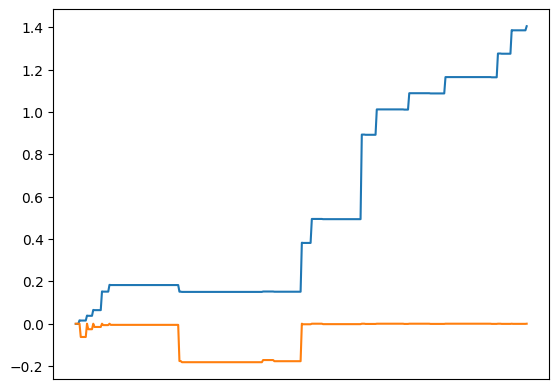

descr,bitcoin-cash,dogecoin,z,x_dif,y_dif,trade_pnl,date,cumulative_pnl,roll_max,drawdown
str,f64,f64,f64,f64,f64,f64,str,f64,f64,f64
"""short""",230.119965,0.074764,1.041103,0.007587,-0.000179,-0.001,"""2023-08-15""",-0.001,-0.001,0.0
null,0.0,0.0,0.0,0.0,0.0,0.0,"""2023-08-16""",-0.001,-0.001,0.0
null,0.0,0.0,0.0,0.0,0.0,0.0,"""2023-08-17""",-0.001,-0.001,0.0
"""close short""",183.800461,0.061057,-0.694186,-0.201284,-0.183337,0.016948,"""2023-08-18""",0.015948,0.015948,0.0
"""long""",187.278076,0.063189,-1.341707,0.018921,0.034913,-0.001,"""2023-08-19""",0.014948,0.015948,-0.062706
…,…,…,…,…,…,…,…,…,…,…
null,0.0,0.0,0.0,0.0,0.0,0.0,"""2024-08-06""",1.385465,1.386465,-0.000721
null,0.0,0.0,0.0,0.0,0.0,0.0,"""2024-08-07""",1.385465,1.386465,-0.000721
null,0.0,0.0,0.0,0.0,0.0,0.0,"""2024-08-08""",1.385465,1.386465,-0.000721


In [6]:
df_returns = df_returns.with_columns(
    roll_max = pl.col('cumulative_pnl').cum_max()
).with_columns(
    drawdown = pl.col('cumulative_pnl')/pl.col('roll_max') - 1.0
)

plt.plot(df_returns['date'], df_returns['cumulative_pnl'])
plt.plot(df_returns['date'], df_returns['drawdown'])
ax = plt.gca()

#hide x-axis
ax.get_xaxis().set_visible(False)
plt.show()